# To extend data one_store -> one_warehouse_stores setup

In [2]:
from shared_imports import *
n_stores = 3

In [2]:
def extend_and_save(path, n_stores):
    data = torch.load(path)
    data_extended = data.repeat(1, n_stores, 1)
    torch.save(data_extended, path)

In [8]:
extend_and_save('data_files/favorita_one_warehouse/weekly_sales.pt', n_stores)

# Analysis on items that are sold at # of stores

In [32]:
# Load the CSV file
file_path = 'data_files/favorita/tensors_row_info.csv'  # Update the file path
df = pd.read_csv(file_path)

# Group by 'item_nbr' and count unique 'store_nbr' for each 'item_nbr'
store_counts = df.groupby('item_nbr')['store_nbr'].nunique()

# Determine the maximum number of stores any item is sold in
max_stores = store_counts.max()

# Initialize a dictionary to store the counts
store_distribution = {}

# Loop through each unique store count found and count how many items have that store count
for count in range(1, max_stores + 1):
    store_distribution[count] = (store_counts == count).sum()

ct = 0
# Printing the results
for stores, num_items in store_distribution.items():
    ct += stores * num_items
    print(f"Number of items sold in exactly {stores} store(s): {num_items}")

Number of items sold in exactly 1 store(s): 10
Number of items sold in exactly 2 store(s): 25
Number of items sold in exactly 3 store(s): 46
Number of items sold in exactly 4 store(s): 78
Number of items sold in exactly 5 store(s): 117
Number of items sold in exactly 6 store(s): 161
Number of items sold in exactly 7 store(s): 174
Number of items sold in exactly 8 store(s): 190
Number of items sold in exactly 9 store(s): 234
Number of items sold in exactly 10 store(s): 221
Number of items sold in exactly 11 store(s): 270
Number of items sold in exactly 12 store(s): 292
Number of items sold in exactly 13 store(s): 315
Number of items sold in exactly 14 store(s): 265
Number of items sold in exactly 15 store(s): 226
Number of items sold in exactly 16 store(s): 149
Number of items sold in exactly 17 store(s): 122
Number of items sold in exactly 18 store(s): 82
Number of items sold in exactly 19 store(s): 41
Number of items sold in exactly 20 store(s): 16
Number of items sold in exactly 21 s

# Construct dataset from items being sold at 16 stores.

In [3]:
import pandas as pd
import torch

def filter_and_construct_data(csv_file_path, tensor_file_path, output_csv_path, output_tensor_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Load the tensor
    data_tensor = torch.load(tensor_file_path)
    
    # Find items sold in more than 16 different stores
    store_counts = df.groupby('item_nbr')['store_nbr'].nunique()
    items_more_than_16_stores = store_counts[store_counts >= 16].index
    
    # Filter DataFrame for these items
    filtered_df = df[df['item_nbr'].isin(items_more_than_16_stores)]
    
    # For each qualifying item, select data for exactly 16 stores
    final_df = pd.DataFrame()
    indices = []
    for item in items_more_than_16_stores:
        temp_df = filtered_df[filtered_df['item_nbr'] == item]
        selected_stores = temp_df['store_nbr'].drop_duplicates().iloc[:16]  # Select the first 16 unique stores
        selected_rows = temp_df[temp_df['store_nbr'].isin(selected_stores)]
        final_df = pd.concat([final_df, selected_rows])
        indices.extend(selected_rows.index.tolist())
    
    # Select corresponding tensors
    final_tensor = data_tensor[indices, :, :]
    
    # Ensure final_tensor is of the shape [X, 16, 240] where X is the number of valid (item, store) pairs
    final_tensor = final_tensor.view(-1, 16, 240)
    
    # Save the new DataFrame and tensor
    final_df.to_csv(output_csv_path, index=False)
    torch.save(final_tensor, output_tensor_path)
    
    print("Filtered data has been saved successfully.")

# Usage
filter_and_construct_data('data_files/favorita/tensors_row_info.csv', 'data_files/favorita/weekly_sales.pt'\
                          , 'data_files/favorita_one_warehouse/tensors_row_info.csv', 'data_files/favorita_one_warehouse/weekly_sales.pt')

Filtered data has been saved successfully.


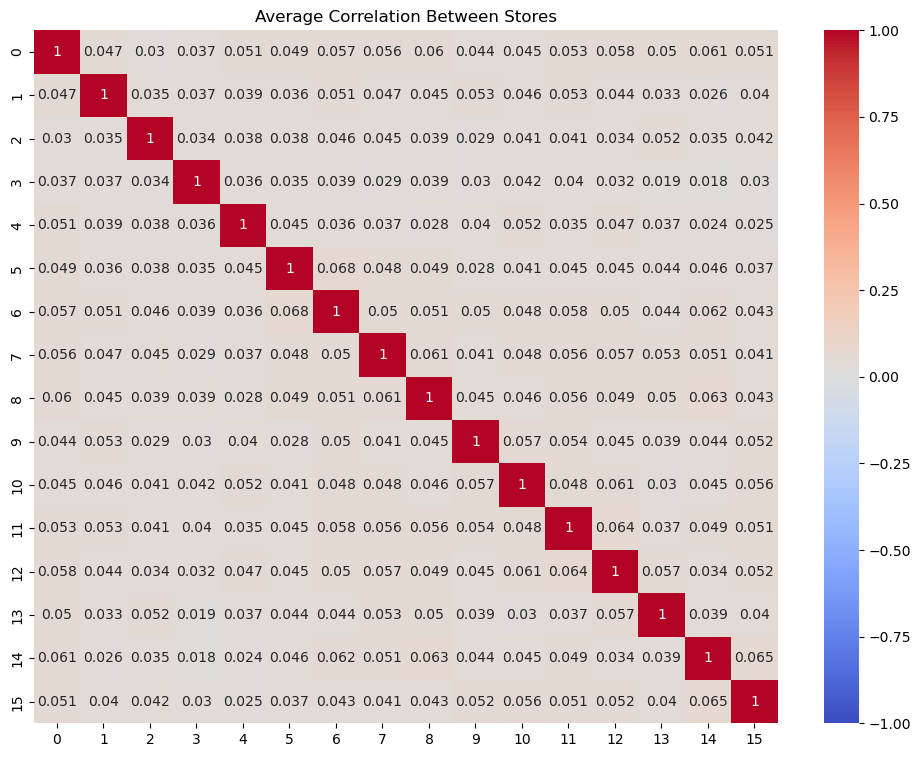

Overall correlation between different stores (using average matrix): 0.0444


In [4]:
# Load the filtered tensor data
filtered_tensor = torch.load('data_files/favorita_one_warehouse/weekly_sales.pt')

# Cut the tensor to only include the first 170 weeks
data = filtered_tensor[:, :, :170]

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate correlation matrix for each sample
corr_matrices = []
overall_correlations = []
for sample in data:
    corr_matrix = np.corrcoef(sample)
    corr_matrices.append(corr_matrix)
    # Calculate overall correlation for this sample
    off_diagonal_correlations = corr_matrix[np.triu_indices(16, k=1)]
    overall_correlation = np.mean(np.abs(off_diagonal_correlations))
    overall_correlations.append(overall_correlation)

# Calculate average correlation matrix
avg_corr_matrix = np.mean(corr_matrices, axis=0)

# Visualize average correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(avg_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Average Correlation Between Stores')
plt.show()

# Calculate overall correlation between different stores (method 1: using average matrix)
off_diagonal_correlations = avg_corr_matrix[np.triu_indices(16, k=1)]
overall_correlation_avg_matrix = np.mean(np.abs(off_diagonal_correlations))
print(f"Overall correlation between different stores (using average matrix): {overall_correlation_avg_matrix:.4f}")

Shape of averaged data: (16, 170)
Shape of correlation matrix: (16, 16)
Overall correlation between different stores: 0.8300


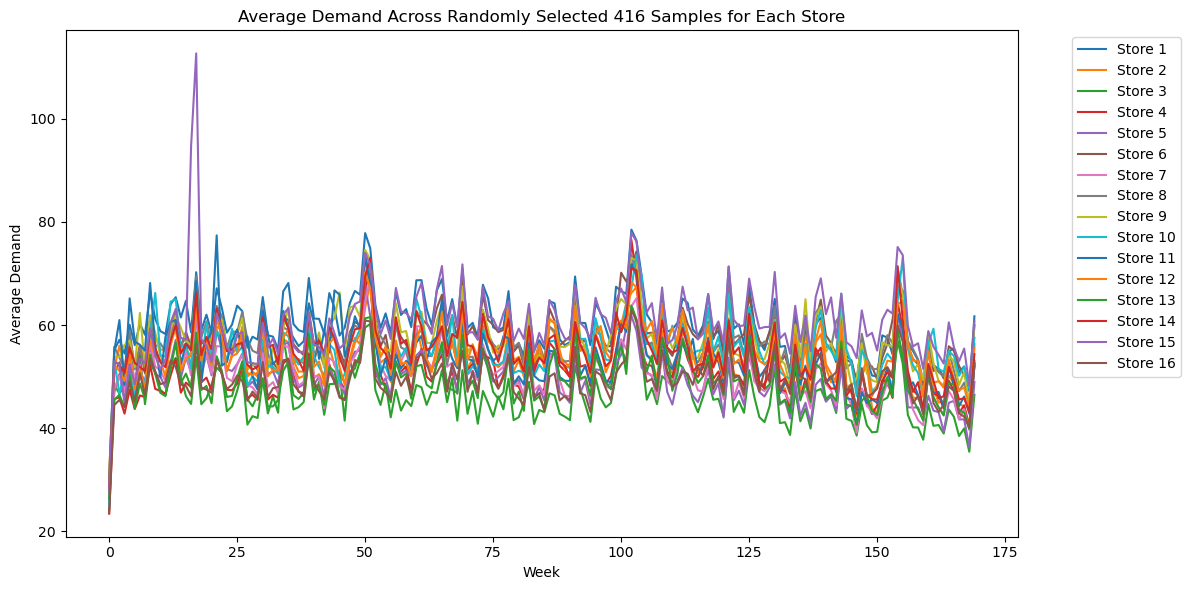

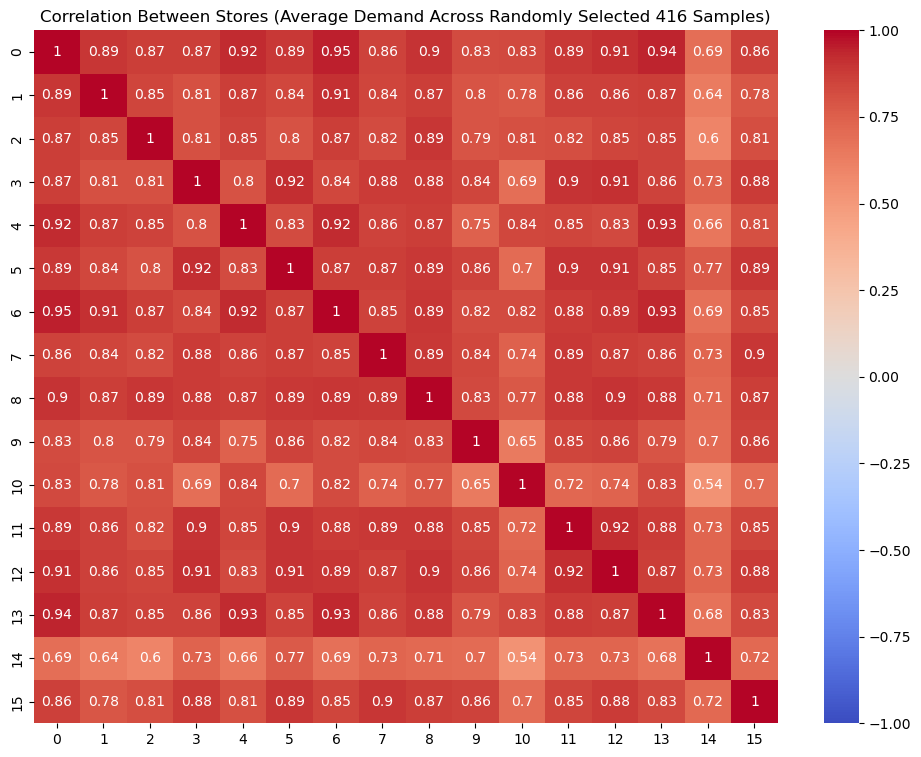

In [17]:
# Load the filtered tensor data
filtered_tensor = torch.load('data_files/favorita_one_warehouse/weekly_sales.pt')
data_origin = filtered_tensor[:, :, :170]  # Shape: (416, 16, 170)

# Reshape the data to combine samples and stores
data_reshaped = data_origin.reshape(-1, 170)  # Shape: (416*16, 170)

# Randomly select 16 unique sets of indices
# Create a list of all indices
all_indices = np.arange(data_reshaped.shape[0])

# Shuffle the indices
np.random.shuffle(all_indices)

# Reshape the shuffled indices into 16 groups of 416 indices each
grouped_indices = all_indices.reshape(16, 416)

# Create the new data by averaging 416 unique sequences for each of the 16 new sequences
data = np.zeros((16, 170))
for i in range(16):
    data[i] = data_reshaped[grouped_indices[i]].mean(axis=0)

print(f"Shape of averaged data: {data.shape}")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate correlation matrix for the 16 demand sequences
corr_matrix = np.corrcoef(data)
print(f"Shape of correlation matrix: {corr_matrix.shape}")

# Calculate overall correlation between different stores
n = corr_matrix.shape[0]
off_diagonal_correlations = corr_matrix[np.triu_indices(n, k=1)]
overall_correlation = np.mean(np.abs(off_diagonal_correlations))
print(f"Overall correlation between different stores: {overall_correlation:.4f}")

# Plot line graph for all 16 stores
plt.figure(figsize=(12, 6))
for i in range(16):
    plt.plot(data[i], label=f'Store {i+1}')
plt.title('Average Demand Across Randomly Selected 416 Samples for Each Store')
plt.xlabel('Week')
plt.ylabel('Average Demand')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Stores (Average Demand Across Randomly Selected 416 Samples)')
plt.show()

In [23]:
# Load the filtered tensor data
filtered_tensor = torch.load('data_files/favorita_one_warehouse/weekly_sales.pt')
data_origin = filtered_tensor[:, :16, :170]  # Use all samples, 16 stores, 170 weeks

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate correlation matrix
def calculate_correlation_matrix(data):
    return np.corrcoef(data)

# Number of samples and sequences
num_samples = 6656
num_sequences = 1

# Calculate total number of possible sequences
total_sequences = data_origin.shape[0] * data_origin.shape[1]

# Create an array of all possible indices
all_indices = np.arange(total_sequences)

# Collect 10 samples, each with 100 unique randomly selected sequences
samples = []
for _ in range(num_samples):
    # Randomly select unique sequences from the remaining indices
    selected_indices = np.random.choice(all_indices, num_sequences, replace=False)
    
    # Remove the selected indices from the pool of available indices
    all_indices = np.setdiff1d(all_indices, selected_indices)
    
    # Calculate sample and store indices
    sample_indices = selected_indices // data_origin.shape[1]
    store_indices = selected_indices % data_origin.shape[1]
    
    # Select the data
    selected_data = data_origin[sample_indices, store_indices, :]
    samples.append(selected_data)

# Convert samples to a numpy array
samples = np.array(samples)

# Stack samples to create a 2D array (10 x 170)
samples_array = np.stack(samples).mean(axis=1)

# Calculate correlation matrix between the 10 samples
correlation_matrix = calculate_correlation_matrix(samples_array)

# Calculate average correlation
off_diagonal_correlations = correlation_matrix[np.triu_indices(num_samples, k=1)]
average_correlation = np.mean(np.abs(off_diagonal_correlations))

print(f"\nAverage correlation between {num_samples} samples: {average_correlation:.4f}")

# Plot heatmap of correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title(f'Correlation Matrix between {num_samples} Samples')
# plt.show()
# Plot line graph for all 10 samples

# plt.figure(figsize=(12, 6))
# for i in range(num_samples):
#     plt.plot(samples_array[i], label=f'Sample {i+1}')
# plt.title('Demand for 10 Samples')
# plt.xlabel('Week')
# plt.ylabel('Demand')
# plt.legend()
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_3305/1056754563.py:41: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.array(samples)
/tmp/ipykernel_3305/1056754563.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)



Average correlation between 6656 samples: 0.1281


In [28]:
# Load the filtered tensor data
filtered_tensor = torch.load('data_files/favorita_one_warehouse/weekly_sales.pt')
data_origin = filtered_tensor[:, :16, :170]  # Use all samples, 16 stores, 170 weeks

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate correlation matrix
def calculate_correlation_matrix(data):
    return np.corrcoef(data)

# Number of samples and sequences
num_samples = 16
num_sequences = 1

# Calculate total number of possible sequences
total_sequences = data_origin.shape[0] * data_origin.shape[1]

# Create an array of all possible indices
all_indices = np.arange(total_sequences)

# Collect 10 samples, each with 100 unique randomly selected sequences
samples = []
for _ in range(num_samples):
    # Randomly select unique sequences from the remaining indices
    selected_indices = np.random.choice(all_indices, num_sequences, replace=False)
    
    # Remove the selected indices from the pool of available indices
    all_indices = np.setdiff1d(all_indices, selected_indices)
    
    # Calculate sample and store indices
    sample_indices = selected_indices // data_origin.shape[1]
    store_indices = selected_indices % data_origin.shape[1]
    
    # Select the data
    selected_data = data_origin[sample_indices, store_indices, :]
    samples.append(selected_data)

# Convert samples to a numpy array
samples = np.array(samples)

# Stack samples to create a 2D array (10 x 170)
samples_array = np.stack(samples).mean(axis=1)

# Calculate correlation matrix between the 10 samples
correlation_matrix = calculate_correlation_matrix(samples_array)

# Calculate average correlation
off_diagonal_correlations = correlation_matrix[np.triu_indices(num_samples, k=1)]
average_correlation = np.mean(np.abs(off_diagonal_correlations))

print(f"\nAverage correlation between {num_samples} samples: {average_correlation:.4f}")

# Plot heatmap of correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title(f'Correlation Matrix between {num_samples} Samples')
# plt.show()
# Plot line graph for all 10 samples

# plt.figure(figsize=(12, 6))
# for i in range(num_samples):
#     plt.plot(samples_array[i], label=f'Sample {i+1}')
# plt.title('Demand for 10 Samples')
# plt.xlabel('Week')
# plt.ylabel('Demand')
# plt.legend()
# plt.tight_layout()
# plt.show()


Average correlation between 16 samples: 0.1028


/tmp/ipykernel_3305/3555230447.py:41: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.array(samples)
/tmp/ipykernel_3305/3555230447.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([416, 170])
Overall correlation between different samples: 0.3039


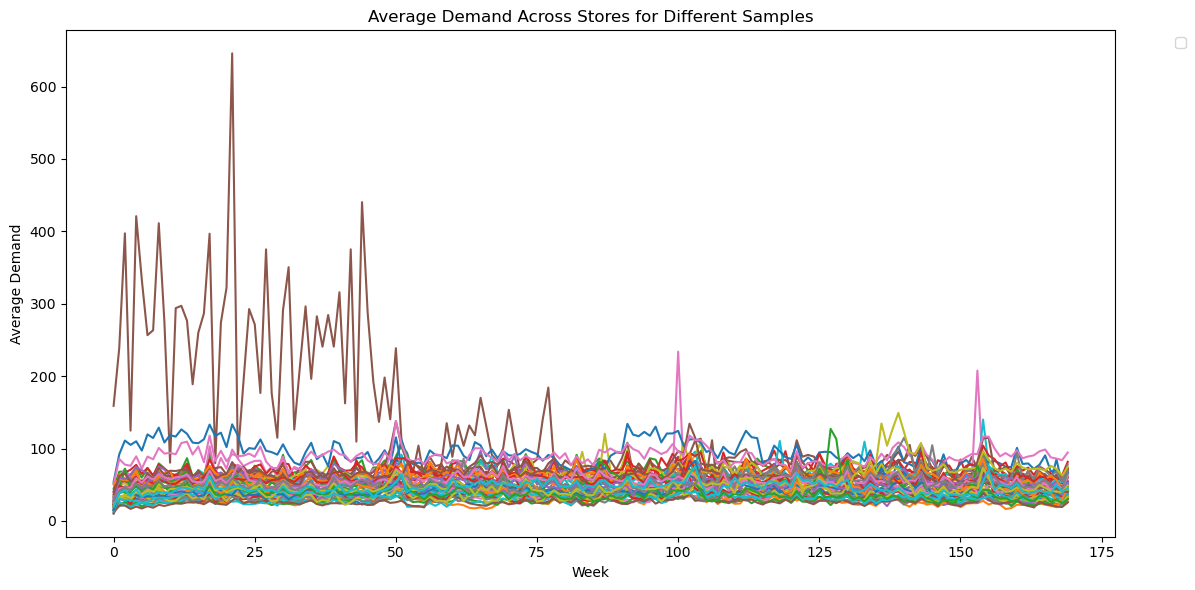

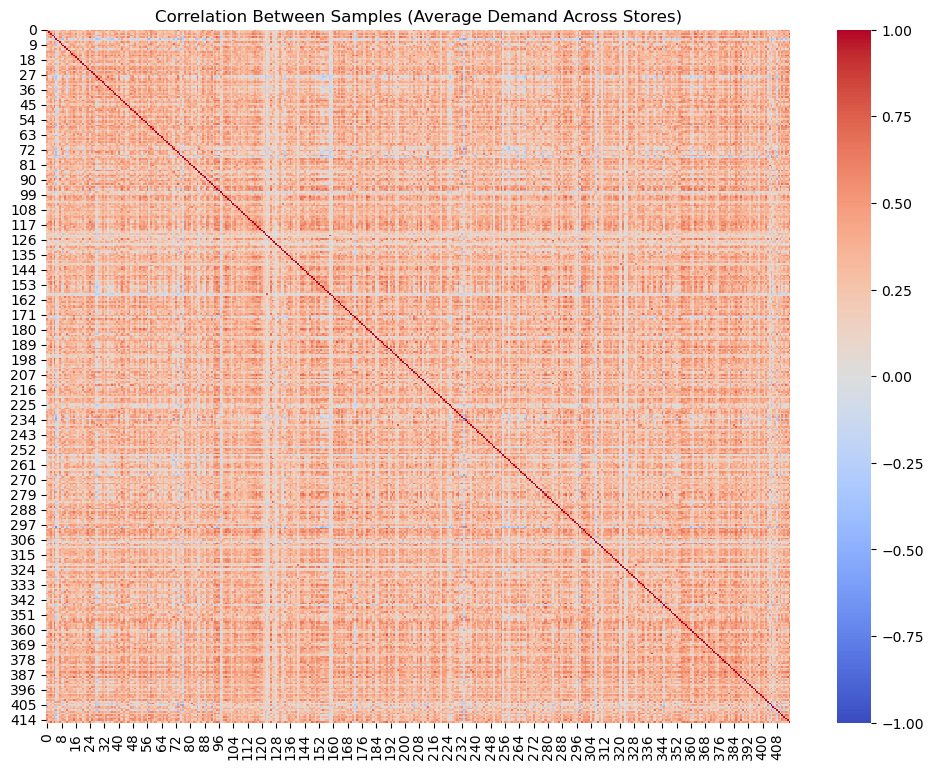

In [ ]:
# Load the filtered tensor data
filtered_tensor = torch.load('data_files/favorita_one_warehouse/weekly_sales.pt')
data_origin = filtered_tensor[:, :16, :170]  # Use all samples, 16 stores, 170 weeks

# Calculate the average over the second dimension (stores)
data = data_origin.mean(dim=1)
print(data.shape)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate correlation matrix for the average data
corr_matrix = np.corrcoef(data)  # Transpose to get correlation between samples
# Calculate overall correlation between different samples
n = corr_matrix.shape[0]
off_diagonal_correlations = corr_matrix[np.triu_indices(n, k=1)]
overall_correlation = np.mean(np.abs(off_diagonal_correlations))
print(f"Overall correlation between different samples: {overall_correlation:.4f}")

# Plot line graph for all samples
plt.figure(figsize=(12, 6))
for i in range(min(50, data.shape[0])):  # Plot first 50 samples or all if less than 50
    plt.plot(data[i], label=f'')
plt.title('Average Demand Across Stores for Different Samples')
plt.xlabel('Week')
plt.ylabel('Average Demand')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize correlation matrix (first 50x50 if more than 50 samples)
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix[:, :], annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Samples (Average Demand Across Stores)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([416, 170])
Overall correlation between different samples: 0.3039


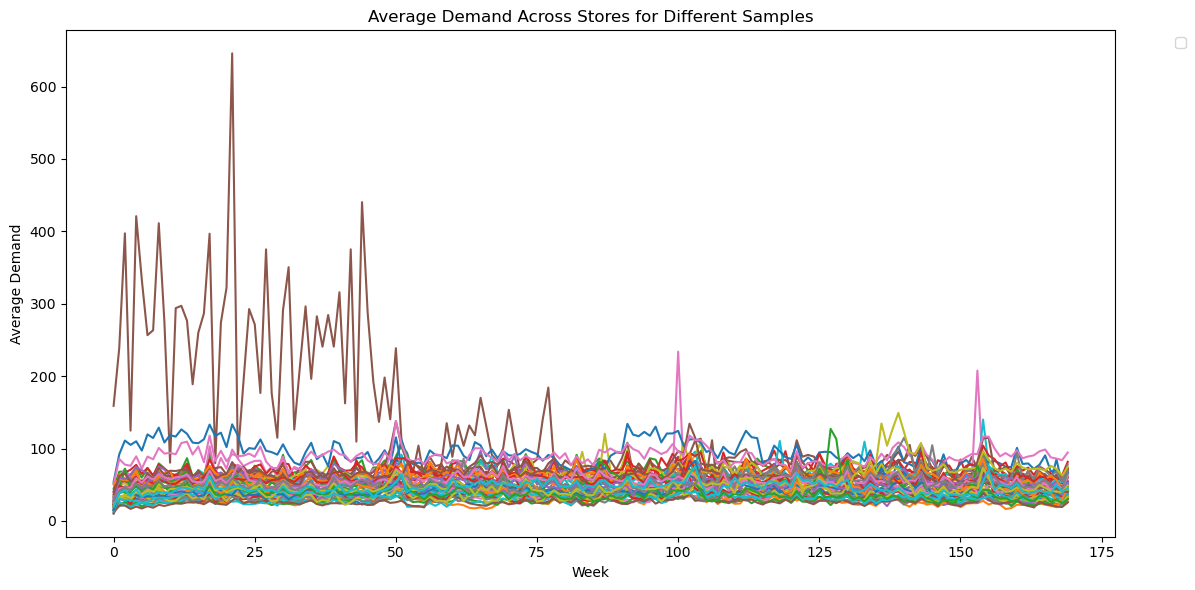

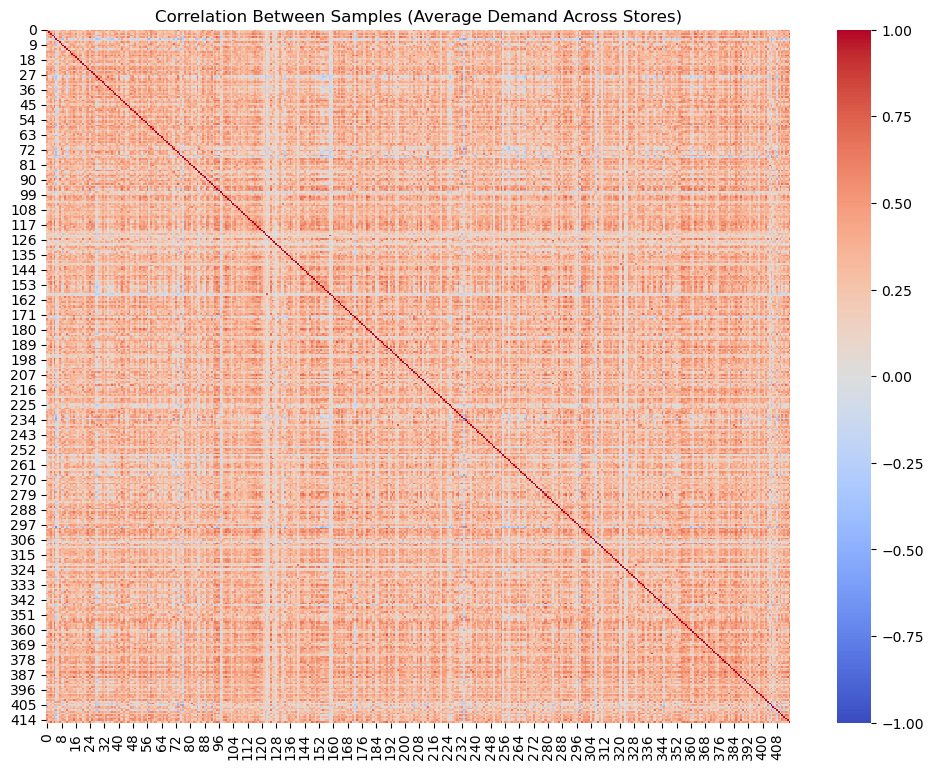

In [ ]:
# Load the filtered tensor data
filtered_tensor = torch.load('data_files/favorita_one_warehouse/weekly_sales.pt')
data_origin = filtered_tensor[:, :16, :170]  # Use all samples, 16 stores, 170 weeks

# Calculate the average over the second dimension (stores)
data = data_origin.mean(dim=1)
print(data.shape)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate correlation matrix for the average data
corr_matrix = np.corrcoef(data)  # Transpose to get correlation between samples
# Calculate overall correlation between different samples
n = corr_matrix.shape[0]
off_diagonal_correlations = corr_matrix[np.triu_indices(n, k=1)]
overall_correlation = np.mean(np.abs(off_diagonal_correlations))
print(f"Overall correlation between different samples: {overall_correlation:.4f}")

# Plot line graph for all samples
plt.figure(figsize=(12, 6))
for i in range(min(50, data.shape[0])):  # Plot first 50 samples or all if less than 50
    plt.plot(data[i], label=f'')
plt.title('Average Demand Across Stores for Different Samples')
plt.xlabel('Week')
plt.ylabel('Average Demand')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize correlation matrix (first 50x50 if more than 50 samples)
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix[:, :], annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Samples (Average Demand Across Stores)')
plt.show()